# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [ ]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import ForwardModelPWEIterative, ForwardModelPWEFullLU, ForwardModelMS,ForwardModelPWEFullPinT
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-10-31 18:37:27,717 - INFO - === Scan Summary (Continuous) ===
2025-10-31 18:37:27,718 - INFO -   Sample space (x-range): 2.500e-04 m
2025-10-31 18:37:27,719 - INFO -   Sample space (z-range): 2.000e-05 m
2025-10-31 18:37:27,721 - INFO -   Probe diameter:         1.250e-05 m
2025-10-31 18:37:27,723 - INFO -   Number of scan points:  1
2025-10-31 18:37:27,724 - INFO -   Steps in z:             62
2025-10-31 18:37:27,726 - INFO -   Detector Pixels:        75000


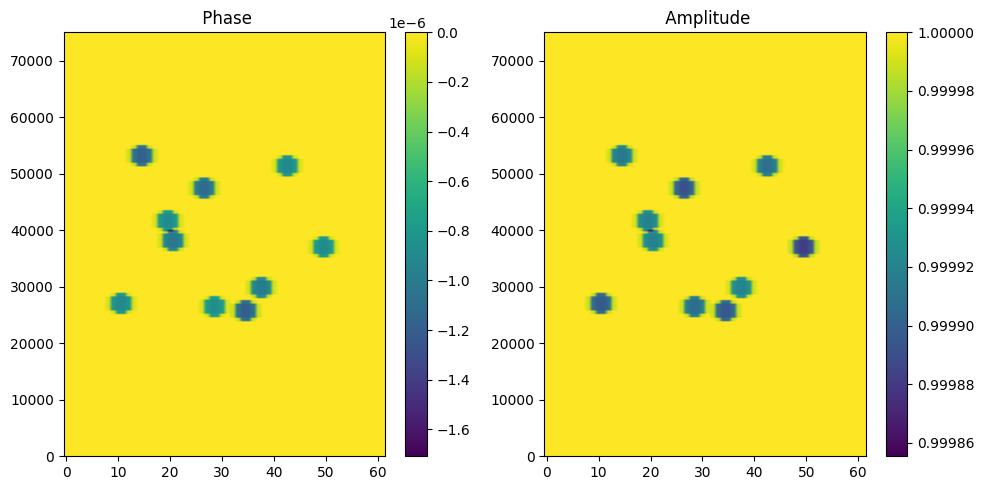

In [2]:
wavelength = 0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index

# --- Probe configuration ---
probe_dimensions_discrete = [50000]
probe_diameter_scale = 0.05
probe_focus = -5e-6                    # focal length [m]
scan_points = 1
step_size = 3                        # pixels between scans

pad_factor = 1.5  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 250e-6]   # meters (sample width)
zlims = [0.0, 20e-6]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength / 2 
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    #probe_angles=(np.linspace(-15,15,3)),
    probe_focus=probe_focus,
    tomographic_projection_90_degree=True,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# # TODO: Make objects move to the centre with padding or define them in min_nx
# # Add 6 spheres of varying positions
# # Base refractive index offsets
delta = 1e-4
beta = 1e-6

# Variation strength (fractional)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length=common_side_length,
        centre=(cx, cz),
        depth=common_depth,
        gaussian_blur=gaussian_blur
    )
ptycho_object.build_field()
# delta = 0.01
# beta = 0.001
# ptycho_object.load_image("/home/dnz75396/thick_ptycho/notebooks/UKRI.tiff", 
#                          real_perturbation=delta, imaginary_perturbation=beta)
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [3]:
# # Solve Full Space Space, Iterative

# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe = ForwardModelPWEIterative(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes)

# # Iterative solution
# u_pwe = forward_model_pwe.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
# intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
#                                                            poisson_noise=True)
# intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
#                                                            poisson_noise=False)

In [4]:
# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe_full = ForwardModelPWEFull(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 use_pit=False)

# # Iterative solution
# u_pwe_full = forward_model_pwe_full.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
# intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=True)
# intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
#                                                            poisson_noise=False)

In [5]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_full = ForwardModelPWEFull(simulation_space,
                                ptycho_object,
                                ptycho_probes,
                                use_pit=True,
                                alpha=1e-6,
                                atol=1e-8,
                                num_workers=8)

# Iterative solution
u_pwe_full = forward_model_pwe_full.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
                                                           poisson_noise=True)
intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
                                                           poisson_noise=False)


#error = np.linalg.norm(u_pwe_full - u_pwe) / np.linalg.norm(u_pwe)

Available CPU cores: 16
Using 8 workers for PiT preconditioner.
Retrieving PiT preconditioner and setting up system...
Creating the Pit preconditioner with 8 workers.
PiT preconditioner retrieval and setup time: 0.79 seconds.

Solving with PiT-preconditioned GMRES...
  Iter   1 | Precond residual: 5.642e-04
  Iter   2 | Precond residual: 1.689e-07
Time with PiT preconditioner: 8.15 seconds.
GMRES converged in 2 iterations.

Forward model creation and solving time: 11.41 seconds.



In [6]:
# print("Relative error between full and iterative PWE solutions:", error)

/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/thick_ptycho/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


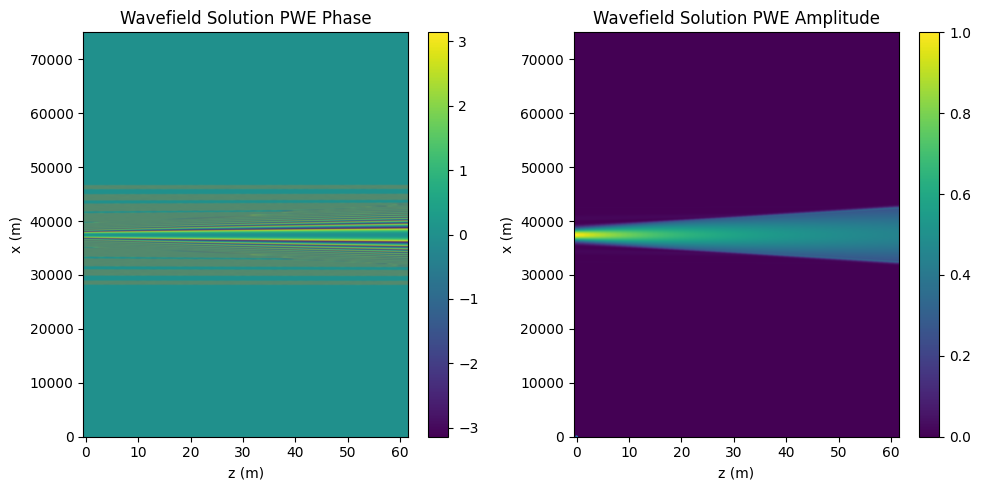

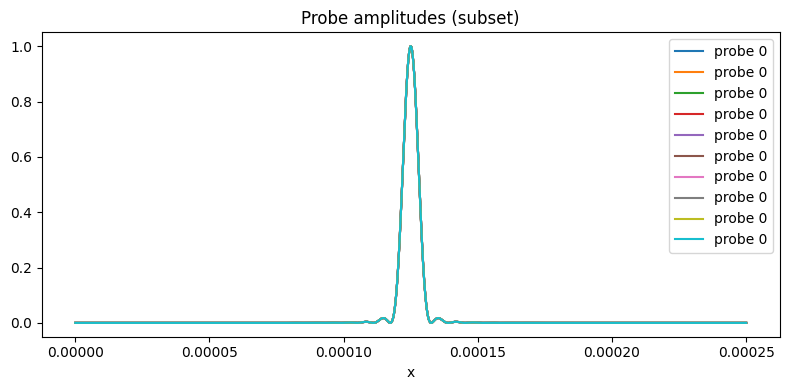

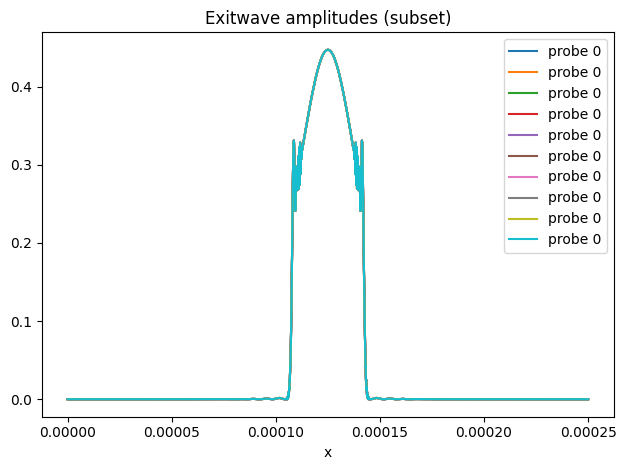

In [7]:
# simulation_space.viewer.plot_two_panels(exit_waves_pwe_full,
#                                         view="phase_amp", 
#                                         title="Exit Waves PWE",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# simulation_space.viewer.plot_single_panel(intensities_pwe_full,
#                                         title="Far-field Intensities PWE",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# simulation_space.viewer.plot_single_panel(intensities_pwe_noisy_full,
#                                         title="Far-field Intensities PWE (Noisy)",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# Select Centre Probe
centre_probe_pwe = u_pwe_full[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = 10#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.num_probes-1, plot_num_probes, dtype=int)
for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe_full[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(simulation_space.x, np.abs(u_pwe_full[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()


### 6. Inverse Problem Assuming Phase
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [8]:
# --- Reconstruction data ---
complex_data = exit_waves_pwe

NameError: name 'exit_waves_pwe' is not defined

In [ ]:
# Create MS Simulation Space
dz = wavelength * 16 # For multi-slice, keep dz larger to reduce number of slices
nz = int(z_range / dz)
discrete_dimensions = (int(min_nx * pad_factor), nz)

# --- Create the SimulationConfig object ---
config_ms = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    probe_focus=probe_focus,
    tomographic_projection_90_degree=False,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)
simulation_space_ms = create_simulation_space(config_ms)
simulation_space_ms.summarize()


In [ ]:
recon_ms = ReconstructorMS(simulation_space_ms, complex_data.squeeze(), phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, complex_data, phase_retrieval=False, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=20)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)

## Phase Retrieval

In [ ]:
# --- Reconstruction data ---
data = intensities_pwe

In [ ]:

recon_ms = ReconstructorMS(simulation_space_ms, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=100,alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space_ms.viewer.plot_two_panels(n_est_ms,view="phase_amp")
simulation_space_ms.viewer.plot_residual(residual_ms)

In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=100)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(n_est_pwe,view="phase_amp")
simulation_space.viewer.plot_residual(residual_pwe)